**Predicting which Round of a Tennis Tournament in which a Match is Played**

**Introduction:** <p> Our goal for this project is to be able to predict which round of a tournament a tennis match occured, from top 128 to finals, based on relevant match data.</p> <p> The first round of a tournament begins with 128 players and after each match the number of players remaining is halved. This continues until quarterfinals(QF), then to semi-finals(SF), and ending with the grand finals(F).</p> <p>This includes data from both the winners and losers and the length of a match. This data was gathered from the 2021 matches played by athletes part of the Association of Tennis Professionals (ATP).</p>



In [64]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(dplyr)
library(rvest)
library(tidymodels)
library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 10)

**Step 1:** <p> Read in the data, and select the potential columns of data that will be used. Since we want to investigate matches that are five sets long, filter for '5' in the 'best_of' column. Finally, split the data into training and testing sets, so that the accuracy of our model can be predicted later. 

In [65]:
tennis_data <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv") %>%
select(winner_name, loser_name, round, best_of, minutes, w_ace, w_svpt, winner_rank, w_bpSaved, l_ace, l_svpt, l_bpSaved, loser_rank) %>%
filter(best_of == 5)
tennis_data

tennis_split <- initial_split(tennis_data, prop = .75, strata = round)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



winner_name,loser_name,round,best_of,minutes,w_ace,w_svpt,winner_rank,w_bpSaved,l_ace,l_svpt,l_bpSaved,loser_rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Novak Djokovic,Jeremy Chardy,R128,5,91,9,57,1,0,3,86,7,61
Frances Tiafoe,Stefano Travaglia,R128,5,111,6,87,64,4,8,83,4,60
Reilly Opelka,Yen Hsun Lu,R128,5,115,18,84,38,1,3,92,5,1009
Taylor Fritz,Albert Ramos,R128,5,203,11,143,31,11,6,142,6,46
Stan Wawrinka,Pedro Sousa,R128,5,96,7,74,18,0,2,91,9,107
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Felix Auger Aliassime,Carlos Alcaraz,QF,5,68,8,43,15,3,1,47,5,55
Daniil Medvedev,Botic Van De Zandschulp,QF,5,143,13,99,2,3,4,114,5,117
Novak Djokovic,Alexander Zverev,SF,5,214,12,150,1,9,16,124,3,4


**Step 2:** <p>The data is currently separated into winner and loser stats. For it to be more useful, we need to combine those stats to make them into totals or averages, depending on which makes more sense for the type of variable. Before we do so, we get rid of the 'NA' rows using the drop_na() function. Then we can compute all the summary statistics in the mutate() functions. We also need to convert the round column into numerical data as it is much easier to work with. We can do so by using the mutate() function once again, creating a column named 'round_n', and using the recode() function within it to assign numerical values to each of the rounds we currently have. In this case we've assigned 1 to be the round of 128, and 7 to be the final, and the respective values in between. Finally, we select round_n, minutes, total_ace, avg_rank, and total_bpSaved as these will be variables that we believe could be influenced by the round of the tournament in which the match is being played. This process will also be applied to the tennis_test data as it will be necessary for analysis occurring later.

In [66]:
tennis_comb <- tennis_train %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                select(round, minutes, total_ace, avg_rank, total_bpSaved)
tennis_comb

tennis_test_comb <- tennis_test %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                select(round, minutes, total_ace, avg_rank, total_bpSaved)

round,minutes,total_ace,avg_rank,total_bpSaved
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
R128,91,12,31.0,7
R128,111,14,62.0,8
R128,115,21,523.5,6
R128,96,9,62.5,9
R128,252,10,90.5,24
⋮,⋮,⋮,⋮,⋮
QF,126,34,25.0,6
QF,68,9,35.0,8
QF,143,17,59.5,8


**Step 3:** <p> To create a summary of this rather large dataset we can group by the round, which is essentially what we're interested in. Then we can summarize the data so that each round is only associated with one row - this allows us to see whether there might be a trend. Then, so that it's easily legible, we want to arrange it so that the data is ordered by the round during which the tournament was played, in this case from the round of 128 (round_n = 1) to the final (round_n = 7). 

In [67]:
tennis_group <- tennis_comb %>%
                mutate(round_n = recode(round, "R128" = 1, "R64" = 2, "R32" = 3, "R16" = 4, "QF" = 5, "SF" = 6, "F" = 7)) %>%
                group_by(round_n) %>%
                summarise_if(is.numeric, mean) %>%
                arrange(round_n)
tennis_group

round_n,minutes,total_ace,avg_rank,total_bpSaved
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,158.3368,18.62176,86.78756,11.860104
2,158.6064,21.02128,67.86702,12.127660
3,145.2083,16.52083,46.76042,10.250000
4,147.7083,17.08333,28.91667,9.625000
5,167.3846,22.30769,21.23077,11.000000
6,156.3333,18.50000,15.50000,9.833333
7,170.0000,21.50000,3.25000,11.500000


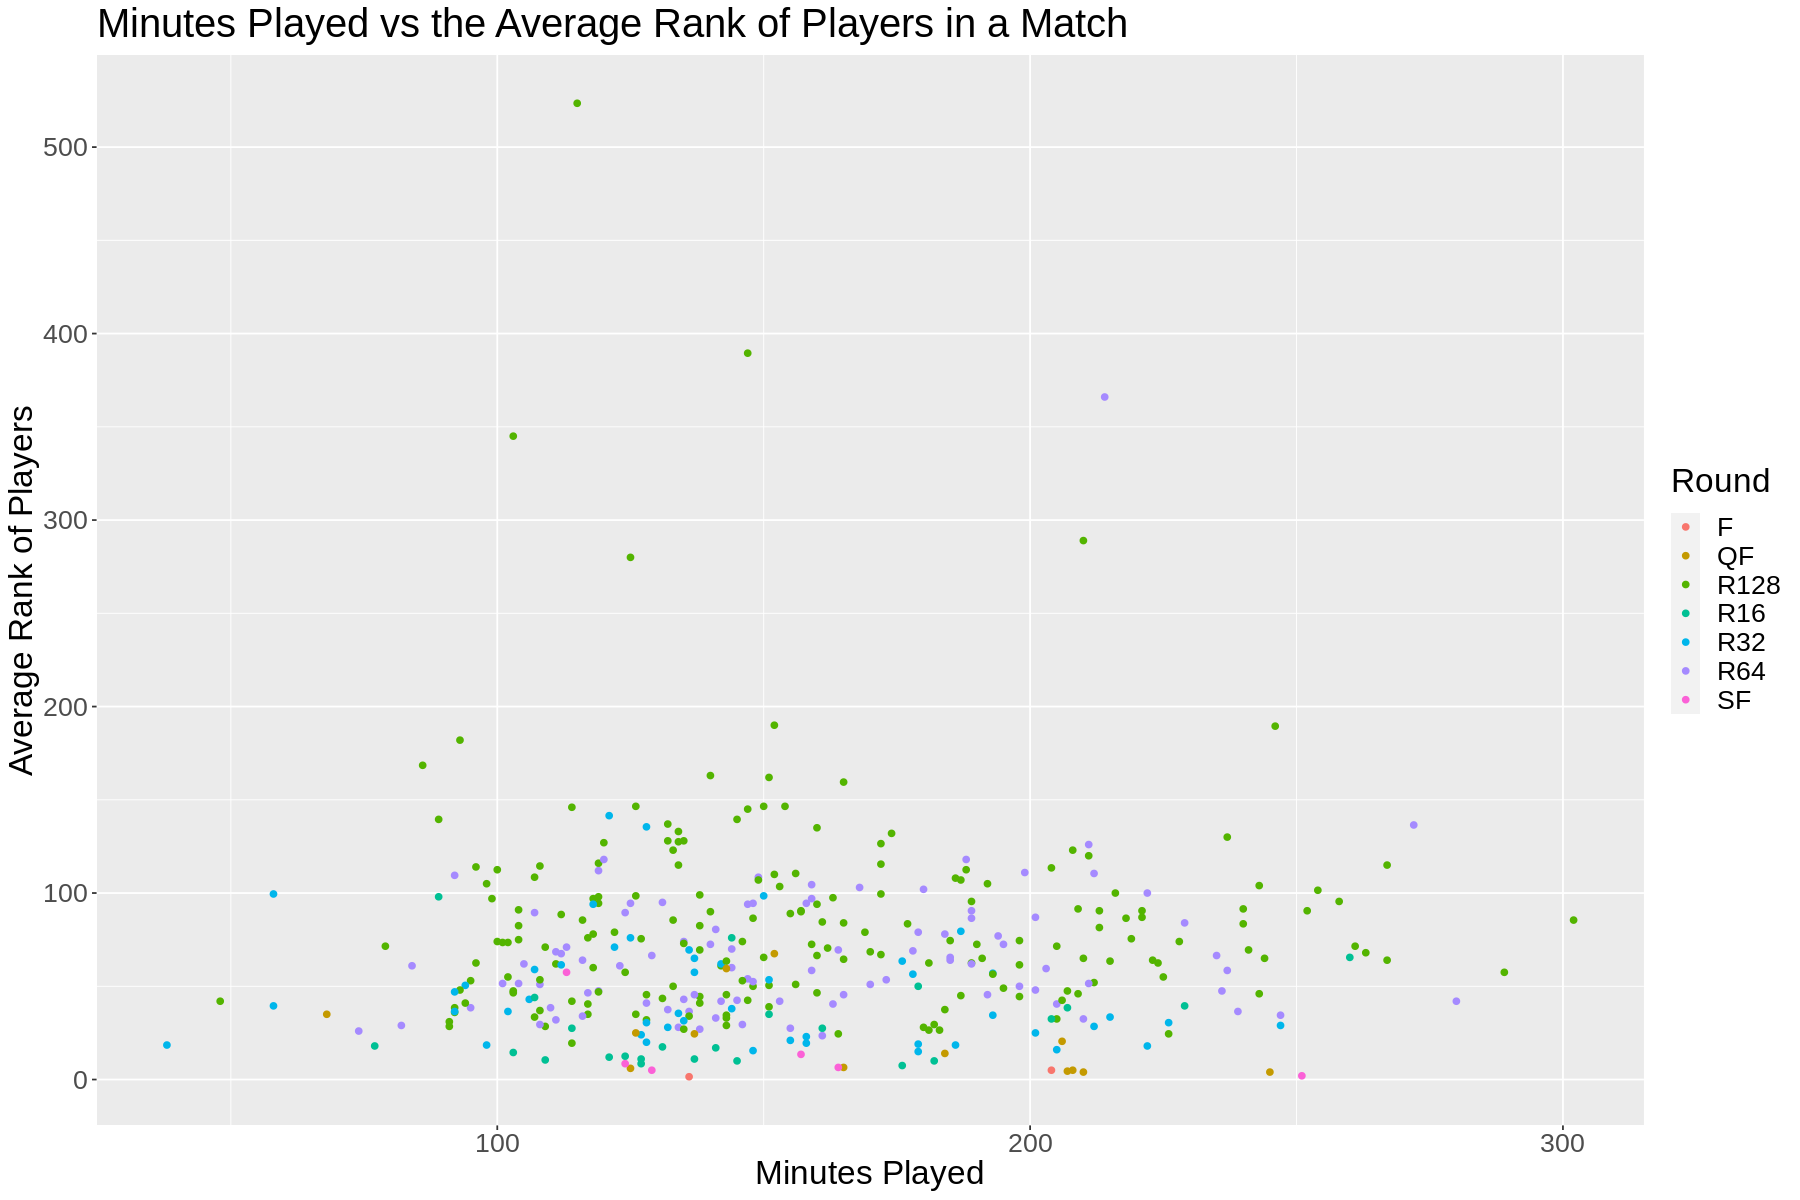

In [68]:
options(repr.plot.width = 15, repr.plot.height = 10) 

tennis_plot <- ggplot(tennis_comb, aes(x = minutes, y = avg_rank)) + 
                geom_point(aes(color = round)) +
                xlab("Minutes Played") +
                ylab("Average Rank of Players") +
                labs(color = "Round") +
                theme(text = element_text(size = 20)) + 
                ggtitle("Minutes Played vs the Average Rank of Players in a Match")
                
tennis_plot

**Step 4:** <p> As we grouped our dataset by round, we have summarized our dataset called tennis_group. Using tennis_group, we made two bar charts of visualizations by putting "round_n" on x-axis. This help us to see the how "minutes" and "average rank" related to different rounds, which gives us a rough idea of what we are looking for when doing the data analysis. We plan to analyze and predict what round of match does a new given point belong by using classification. When we saw these two graphs, we noticed that as that the bigger number the round is, the average ranks of players are smaller. This means that higher ranking players tend to play to further rounds since our data indicates that round 128 is round 1 here and round final is round 7 here. Also, I put color to fill out the third variable in each bar chart. In the first one graph we see that even though the minutes of different rounds are similar, we see darker color in bigger number of rounds. Also in the second graph, it seems like low ranking players play longer time comparing to high ranking players as the color goes darker as well. Therefore through these two visualizations we may assume that high ranking players play slightly less time and they are most likely going into further rounds. <p>

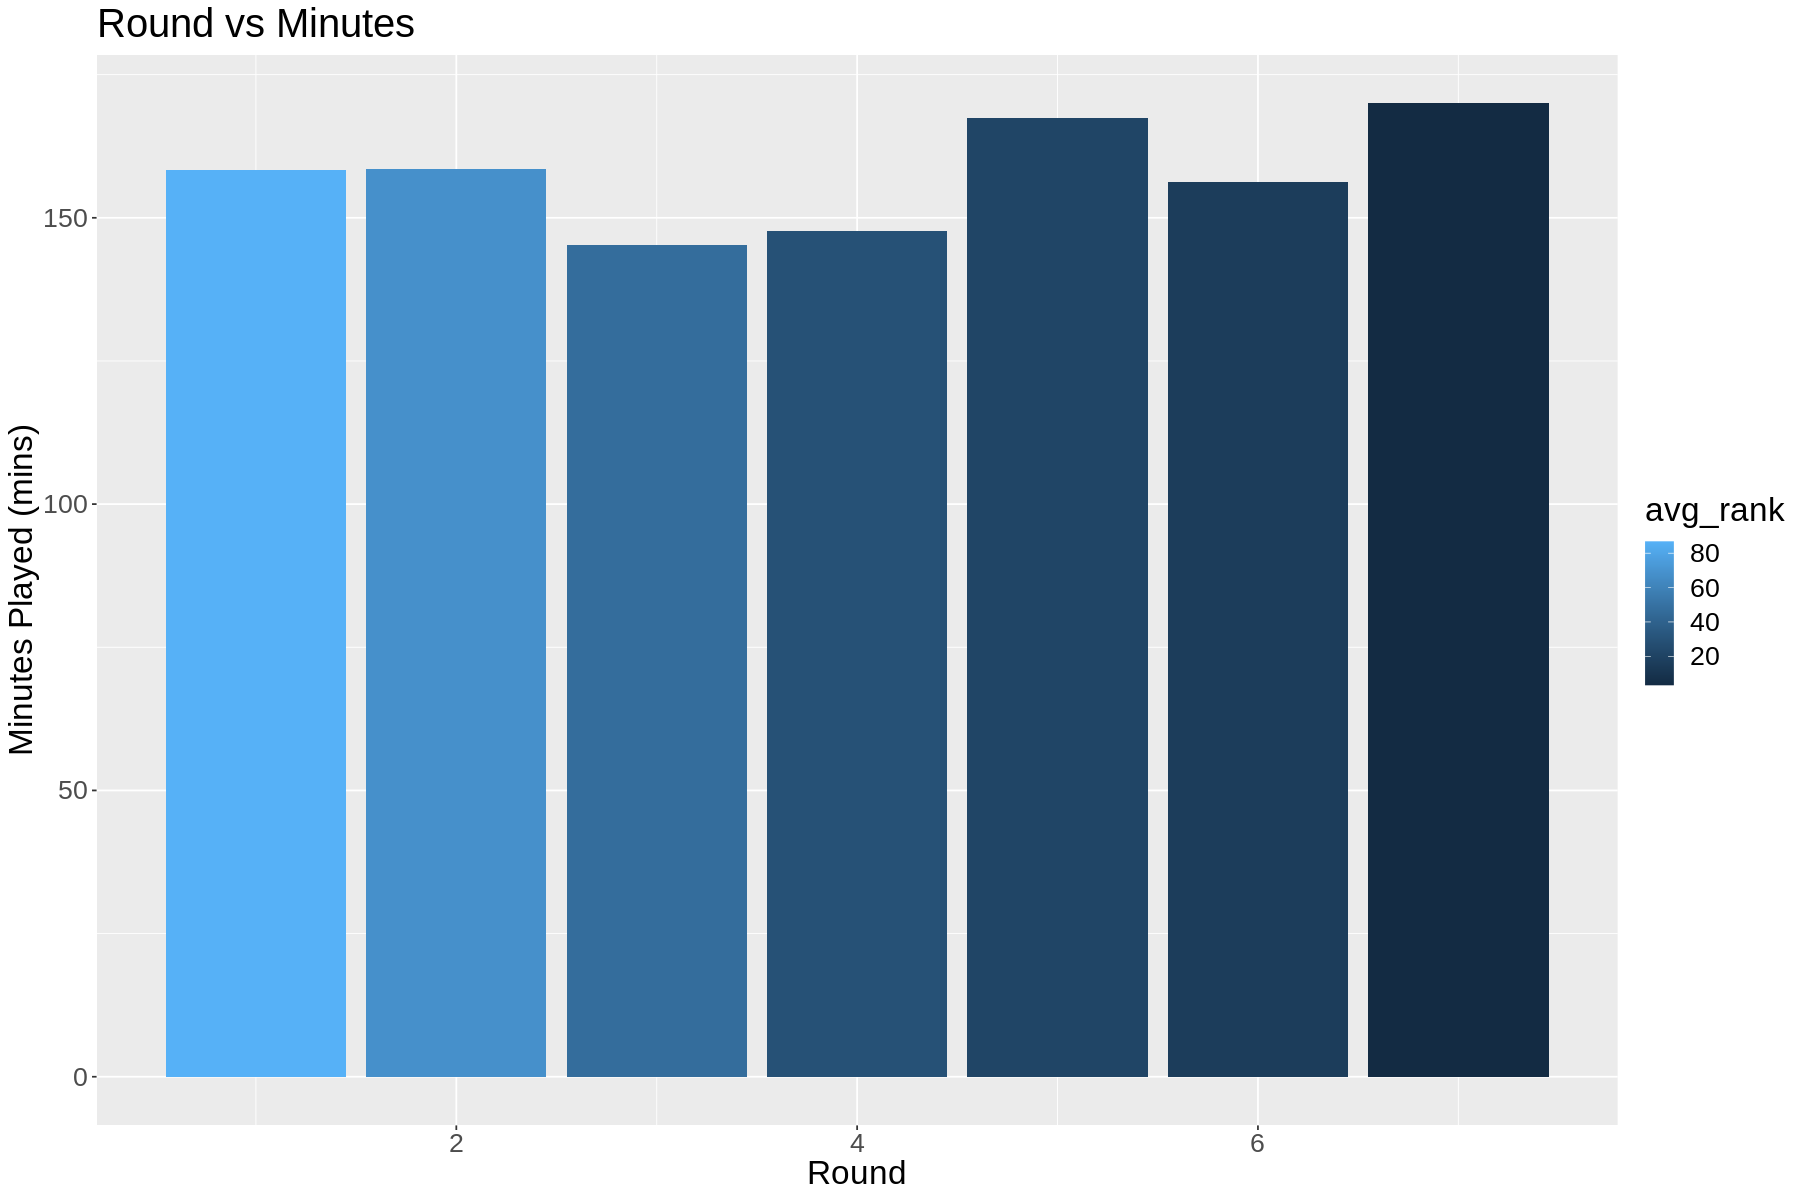

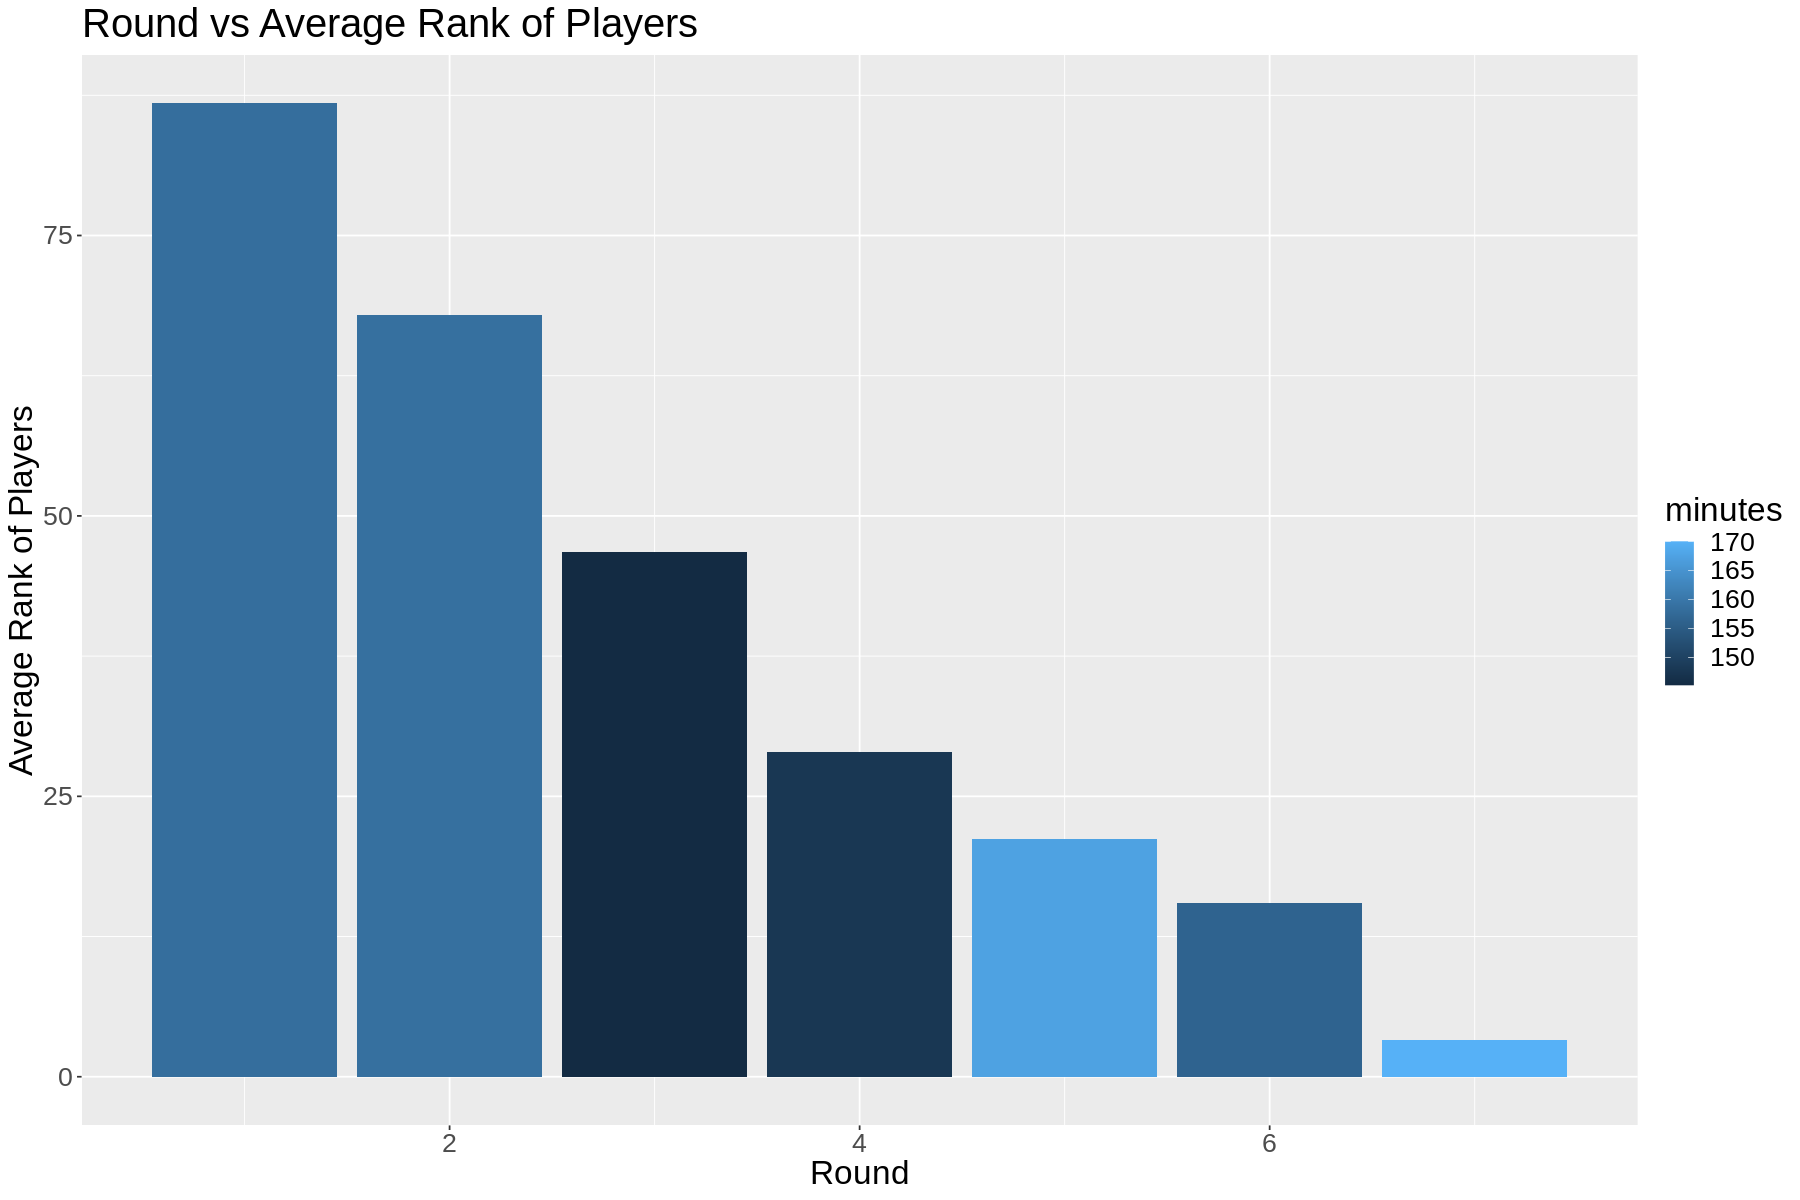

In [69]:
options(repr.plot.width = 15, repr.plot.height = 10) 

round_vs_minutes_bar <- ggplot(tennis_group, aes(x = round_n, y = minutes, fill = avg_rank)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Minutes Played (mins)") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Minutes")
round_vs_minutes_bar


round_vs_avg_rank_bar <- ggplot(tennis_group, aes(x = round_n, y = avg_rank, fill = minutes)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Average Rank of Players") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Average Rank of Players")
round_vs_avg_rank_bar

In [70]:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("classification") 

tennis_recipe <- recipe(round ~ ., data = tennis_comb) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [71]:
tennis_vfold <- vfold_cv(tennis_comb, v = 3, strata = round)

tennis_workflow <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


! Fold1: internal: No observations were detected in `truth` for level(s): 'F'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): 'F'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4233602,3,0.024077587,Model01
1,roc_auc,hand_till,0.5357313,3,0.004933261,Model01
3,accuracy,multiclass,0.4471499,3,0.019613259,Model02
3,roc_auc,hand_till,0.5822230,3,0.015010476,Model02
5,accuracy,multiclass,0.4762313,3,0.005952625,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,hand_till,0.5586954,3,0.01084949,Model08
13,accuracy,multiclass,0.5051860,3,0.01264100,Model09
13,roc_auc,hand_till,0.5636010,3,0.01878432,Model09


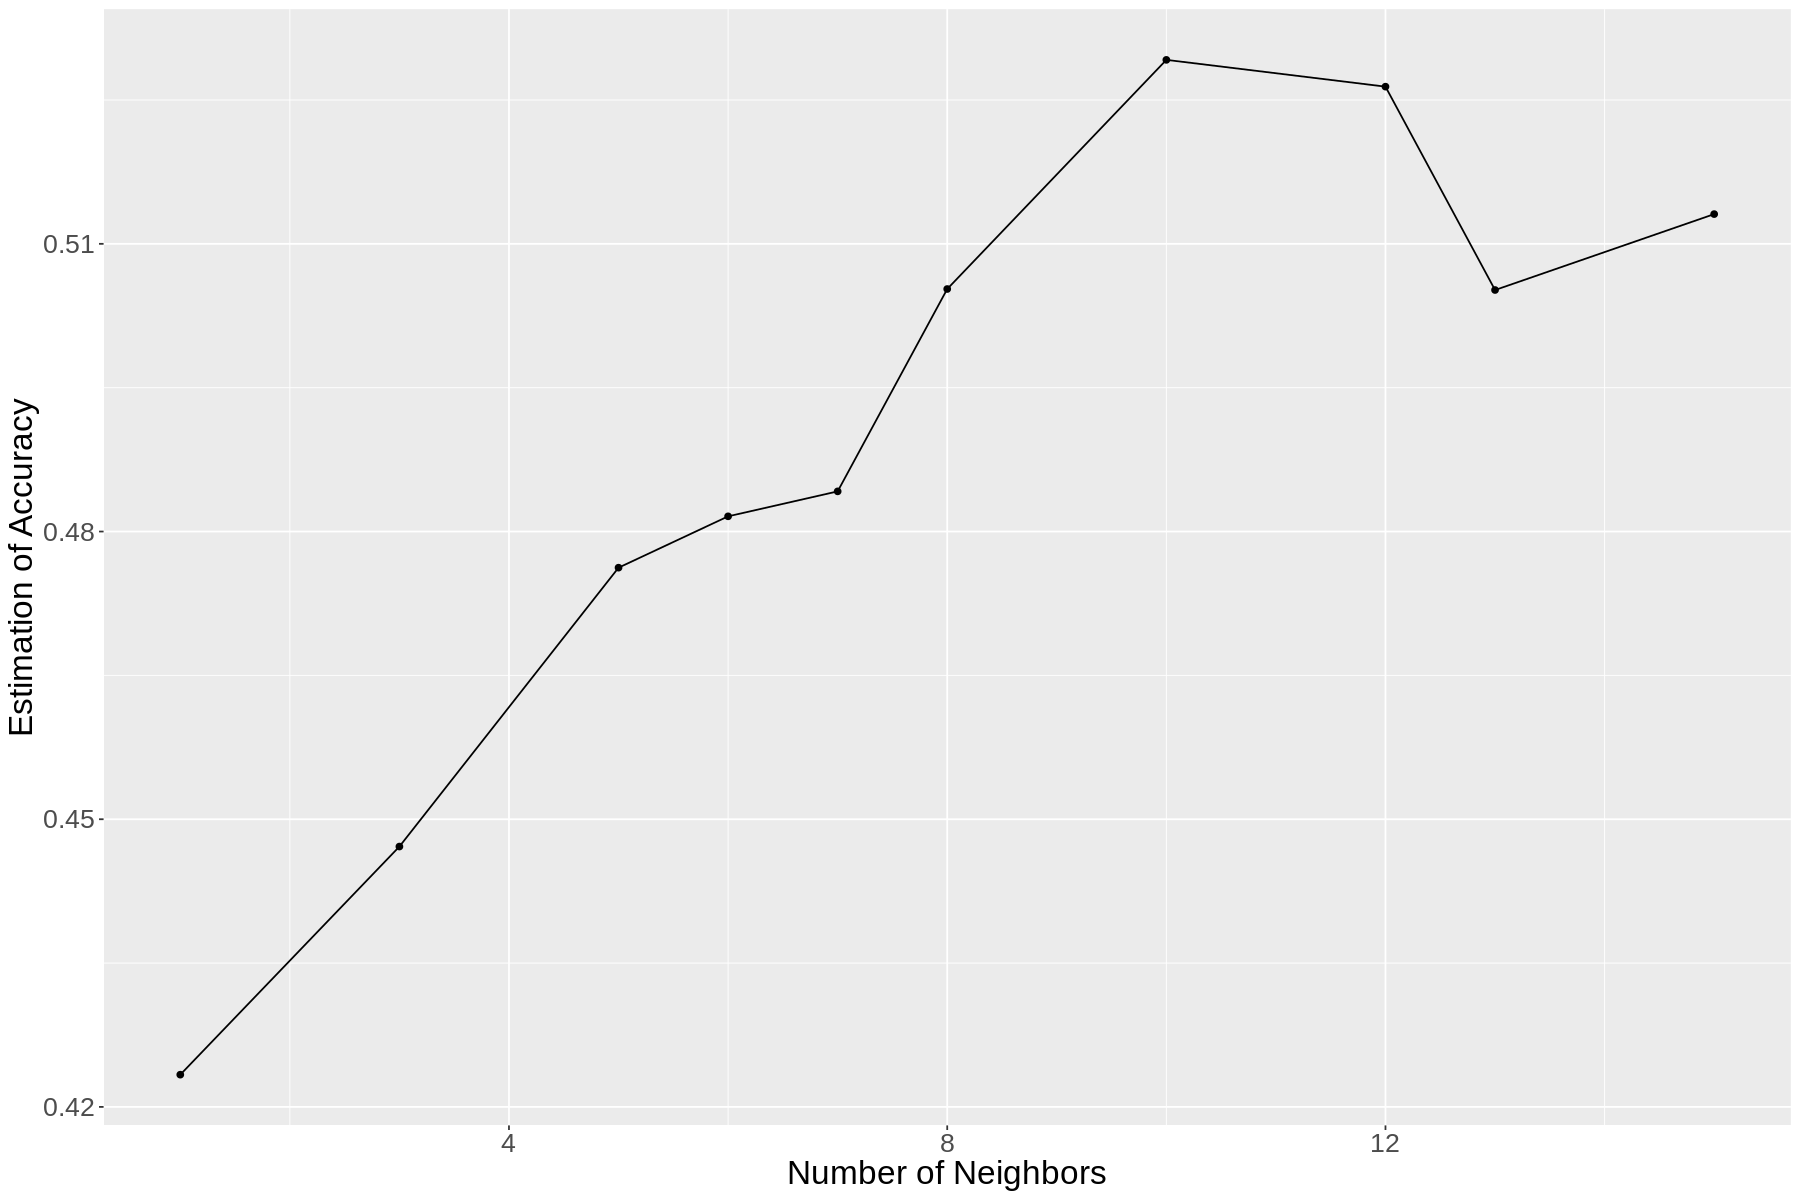

In [72]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100))

tennis_results <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec) %>%
tune_grid(resamples = tennis_vfold, grid = 10) %>%
collect_metrics()
tennis_results

accuracy <- tennis_results %>%
filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Number of Neighbors", y = "Estimation of Accuracy") +
theme(text = element_text(size = 20))
cross_val_plot

In [73]:
tennis_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
set_engine("kknn") %>%
set_mode("classification")

tennis_fit <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec2) %>%
fit(data = tennis_comb)
tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~14, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5026316
Best kernel: rectangular
Best k: 14

In [74]:
tennis_predictions <- predict(tennis_fit, tennis_test_comb) %>%
bind_cols(tennis_test_comb)%>%
mutate(round=as_factor(round))
tennis_predictions

.pred_class,round,minutes,total_ace,avg_rank,total_bpSaved
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
R128,R128,203,17,38.5,17
R128,R128,226,17,48.5,24
R64,R128,141,8,67.0,9
R128,R128,162,22,41.0,11
R128,R128,166,23,70.0,14
⋮,⋮,⋮,⋮,⋮,⋮
R128,R32,235,29,18.0,18
R128,R32,243,24,50.0,16
R64,R32,116,9,38.0,9


Step 4:
Run a cross-validation on each train/validation split by resampling the data.


In [75]:
resample_fit<- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec2) %>%
       fit_resamples(resamples = tennis_vfold)
resample_fit

! Fold1: internal: No observations were detected in `truth` for level(s): 'F'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): 'F'
Com...



splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [76]:
tennis_metrics<-collect_metrics(resample_fit)
tennis_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.5078527,3,0.009987154
roc_auc,hand_till,0.5724823,3,0.016501765


In [77]:
knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn")%>%
set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [78]:
knn_results <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = tennis_vfold, grid = 10) %>%
collect_metrics()
knn_results

! Fold1: internal: No observations were detected in `truth` for level(s): 'F'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): 'F'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4233602,3,0.024077587,Model01
1,roc_auc,hand_till,0.5357313,3,0.004933261,Model01
2,accuracy,multiclass,0.4233602,3,0.024077587,Model02
2,roc_auc,hand_till,0.5440384,3,0.002232263,Model02
5,accuracy,multiclass,0.4762313,3,0.005952625,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,roc_auc,hand_till,0.5623262,3,0.01363019,Model08
13,accuracy,multiclass,0.5051860,3,0.01264100,Model09
13,roc_auc,hand_till,0.5636010,3,0.01878432,Model09


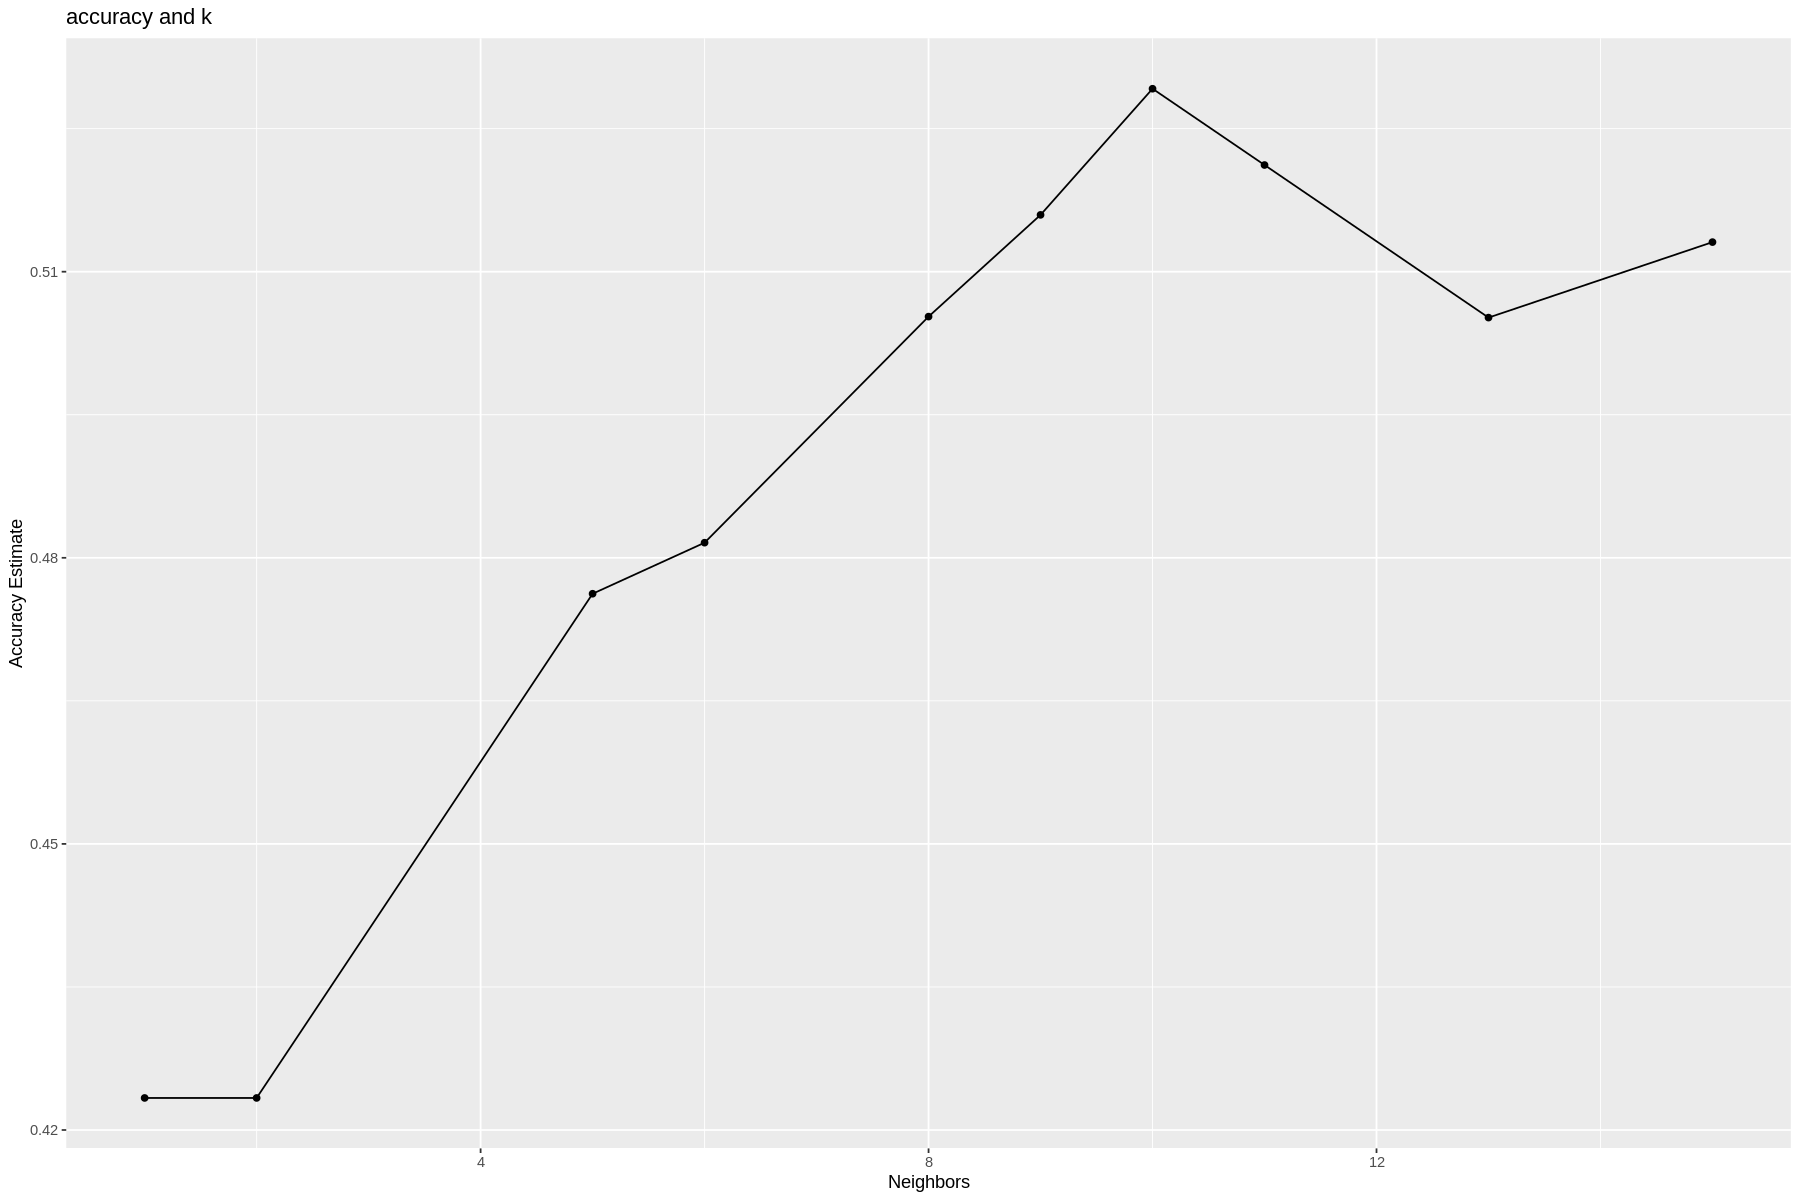

In [82]:
accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

 accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("accuracy and k")
 accuracy_versus_k

**Discussion:** <p> By using knn - classification, we find neighbors = 14 is the best value to predict. Even though we haven’t reach 50% of estimation of accuracy (we have the value around 0.496). This may because of the huge number difference between type of rounds. For example there are many round R128 but for round final there are only three of them. Also, we found that our prediction seems unusual since usually people would predict the winner or the score of a match yet we are predicting what round of a tournament a tennis match occurred, based on the data. We see that the .pred.class and the actual “round” is somehow matched. All may because of the values we have chose to do the prediction. And as the stand error plot indicates that we have less error as we increase the neighbors we choose beside a point that we want to predict. Therefore our data analysis works with what we want to predict based on what we chose. However we may want to predict something else next time because we find that the results of prediction is not quite strong.
</p>